# Setup

In [1]:
import warnings
import os
import pathlib
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import json
from typing import Dict

from sklearn import metrics

from pmdarima.model_selection import train_test_split as time_train_test_split

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

import optuna
from optuna.integration.mlflow import MLflowCallback
from optuna.integration import XGBoostPruningCallback

from flexitext import flexitext

import mlflow

import lightning.pytorch as pl

warnings.filterwarnings("ignore")

c:\Users\esri\miniconda3\envs\aqi_forecast\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
%load_ext autoreload
%autoreload 2

from helper_functions import xgb_helper, xgb_engine

In [3]:
pl.seed_everything(42)

Global seed set to 42


42

In [4]:
root_dir = pathlib.Path(os.getcwd()).parent
raw_data_dir = root_dir / "data/0_raw"
processed_data_dir = root_dir / "data/1_processed"
experiment_dir = root_dir / "experiment"
secret_dir = root_dir / "secrets"

In [5]:
processed_file_name = f"klhk_usable_linearimputed.csv"
processed_file_path = processed_data_dir / processed_file_name

# Data Reading

In [6]:
raw_df = pd.read_csv(processed_file_path)
raw_df.head()

,Unnamed: 0,stasiun,pm10,pm2.5,so2,co,o3,no2,hc,pm 2.5 sedang,pm 2.5 tidak sehat,read_time,lin_pm25
0,1992,Bekasi Kayuringin,62.0,96.0,40.0,15.0,45.0,28.0,70.0,55.4,150.4,2023-06-01 00:00:00,96.0
1,1993,Bekasi Kayuringin,62.0,97.0,41.0,15.0,45.0,28.0,70.0,55.4,150.4,2023-06-01 01:00:00,97.0
2,1994,Bekasi Kayuringin,63.0,97.0,42.0,15.0,45.0,28.0,70.0,55.4,150.4,2023-06-01 02:00:00,97.0
3,1995,Bekasi Kayuringin,63.0,98.0,42.0,15.0,45.0,29.0,70.0,55.4,150.4,2023-06-01 03:00:00,98.0
4,1996,Bekasi Kayuringin,62.0,97.0,43.0,15.0,45.0,29.0,70.0,55.4,150.4,2023-06-01 04:00:00,97.0


# Training

## MLPills
https://mlpills.dev/time-series/xgboost-to-forecast-univariate-time-series-data/

In [65]:
# filtered_df = raw_df[raw_df['stasiun'] == 'Bekasi Kayuringin'][['read_time','lin_pm25']]
# filtered_df = filtered_df.set_index(['read_time'])
# # filtered_df = filtered_df.drop(columns=[''])
# df_logret = np.log(filtered_df).diff()
# df_logret.dropna(inplace=True)

<Axes: xlabel='read_time'>

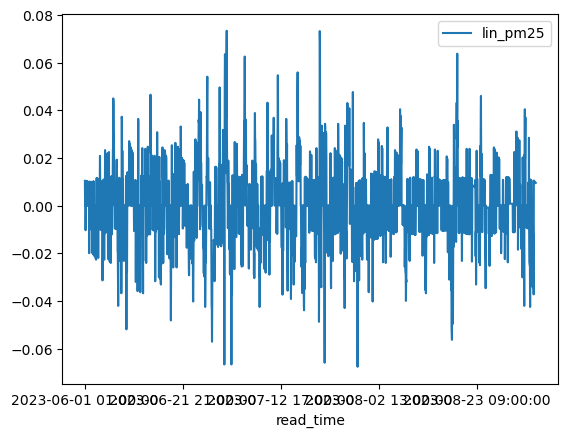

In [66]:
# df_logret.plot()

In [67]:
# def reframe_to_supervised(df:pd.Series, window_size=7):
#     # Initialize empty dataframe
#     df_supervised = pd.DataFrame()

#     # Define columns names
#     X_columns = [f't-{window_size-i}' for i in range(window_size)]
#     columns = X_columns + ['target']

#     # Iterate
#     for i in range(0, df.shape[0] - window_size):
#         # Extract the last "window_size" observations and target
#         # value and create an individual dataframe with this info
#         df_supervised_i = pd.DataFrame([df.values[i:i+window_size+1]],
#                                       columns=columns,
#                                       index=[df.index[i+window_size]])

#         # Add to the final dataframe
#         df_supervised = pd.concat((df_supervised, df_supervised_i),
#                                    axis=0)

#     return df_supervised

In [68]:
# df_supervised = reframe_to_supervised(df_logret['lin_pm25'], window_size=7)

In [111]:
# # Define the proportions for train, validation, and test sets
# train_frac = 0.6  # 60% of the data for training
# val_frac = 0.2    # 20% for validation
# test_frac = 0.2   # 20% for testing

# # Calculate the split indices
# total_len = len(df_supervised)
# train_len = int(total_len * train_frac)
# val_len = int(total_len * val_frac)

# # Split the DataFrame into train, validation, and test sets
# df_train = df_supervised[:train_len]
# df_val = df_supervised[train_len:train_len + val_len]
# df_test = df_supervised[train_len + val_len:]

In [113]:
# # Training set
# X_train = df_train.drop(columns=['target'])
# y_train = df_train['target']

# # validation set
# X_val = df_val.drop(columns=['target'])
# y_val = df_val['target']

In [114]:
# # Convert the datasets into DMatrix
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dval = xgb.DMatrix(X_val)

# # Set XGBoost parameters
# param = {
#     'max_depth': 3,
#     'eta': 0.3,
#     'objective': 'reg:squarederror'
# }

# # Number of boosting rounds
# num_round = 100

# # Train the model
# bst = xgb.train(param, dtrain, num_round)

# # Predict the target for the val set
# y_pred = bst.predict(dval)

# # Calculate and print the RMSE
# rmse = metrics.mean_squared_error(y_val, y_pred, squared=False)
# print(f"RMSE: {rmse}")

RMSE: 0.012398743038769307


In [120]:
# pm_minus_period = filtered_df.copy()

# pm_minus_period = pm_minus_period.assign(lin_pm25_prev=pm_minus_period['lin_pm25'].shift(1))
# pm_minus_period = pm_minus_period.dropna()

In [117]:
# y_pred = pd.DataFrame(data = y_pred, index=y_val.index).rename(columns={0:"lin_pm25_pred"})

In [118]:
# # XGBoost forecasted prices
# y_pred_prices_xgb = pm_minus_period.lin_pm25_prev * np.exp(y_pred.lin_pm25_pred)
# y_pred_prices_xgb = y_pred_prices_xgb.dropna()

<Axes: xlabel='read_time'>

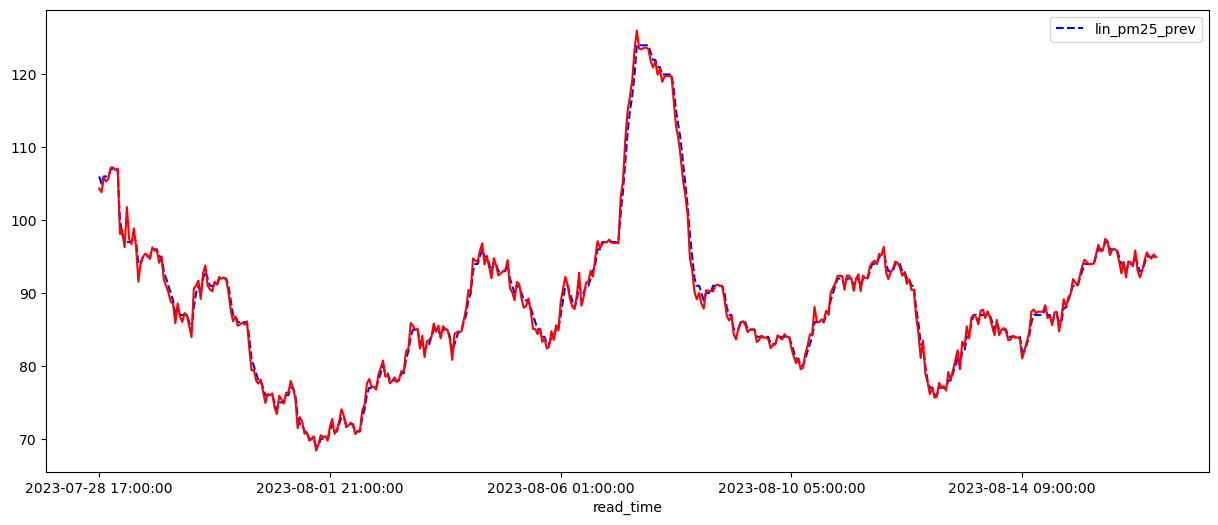

In [119]:
# fig, ax = plt.subplots(figsize = (15,6))

# pm_minus_period[pm_minus_period.index.isin(y_pred_prices_xgb.index)].drop(columns='lin_pm25').plot(
#     ax=ax,
#     color='blue',
#     style='--',
#     label='true value'
# )
# y_pred_prices_xgb.plot(
#     ax=ax,
#     color='red',
#     label='xgb predicted'
# )

In [142]:
# # Convert the test_df to a DMatrix, which is the data structure XGBoost uses
# test_dmatrix = xgb.DMatrix(df_test.drop(columns=['target']))

# # Use the trained model to make predictions on the test data
# inference = bst.predict(test_dmatrix)

# inference = pd.DataFrame(data = inference, index=y_test.index).rename(columns={0:"lin_pm25_pred"})
# inference = pm_minus_period.lin_pm25_prev * np.exp(inference.lin_pm25_pred)
# inference = inference.dropna()
# inference = pd.DataFrame(inference).rename(columns={0:"lin_pm25_pred"})
# inference

,lin_pm25_pred
2023-08-16 20:00:00,94.911122
2023-08-16 21:00:00,93.231414
2023-08-16 22:00:00,93.814238
2023-08-16 23:00:00,95.353132
2023-08-17 00:00:00,96.582424
...,...
2023-09-04 19:00:00,84.143094
2023-09-04 20:00:00,84.955214
2023-09-04 21:00:00,85.883156
2023-09-04 22:00:00,86.718596


In [145]:
# result = inference.copy()
# true_test_value = pm_minus_period[pm_minus_period.index.isin(inference.index)]['lin_pm25_prev']
# result = result.assign(lin_pm25_prev=true_test_value)
# result = result.rename(columns={'lin_pm25_prev':'true_values', 'lin_pm25_pred':'predicted_values'})

In [147]:
# rmse = np.sqrt(((result['true_values'] - result['predicted_values']) ** 2).mean())
# rmse

0.9655073605722597

<Axes: xlabel='read_time'>

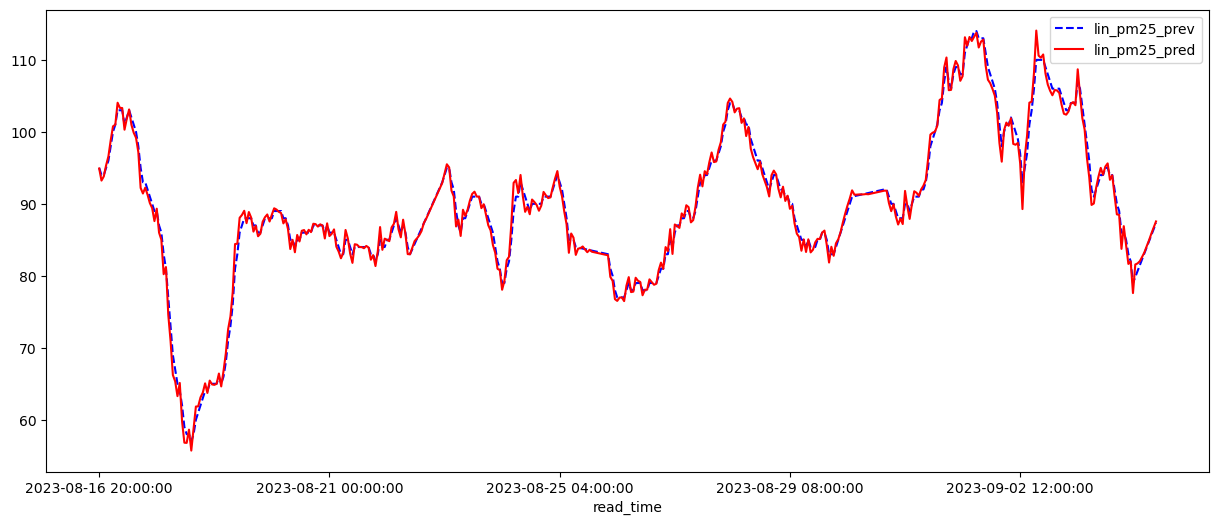

In [141]:
# fig, ax = plt.subplots(figsize = (15,6))

# pm_minus_period[pm_minus_period.index.isin(inference.index)].drop(columns='lin_pm25').plot(
#     ax=ax,
#     color='blue',
#     style='--',
#     label='true value'
# )
# inference.plot(
#     ax=ax,
#     color='red',
#     label='xgb predicted'
# )

## Michael Fuchs
https://michael-fuchs-python.netlify.app/2020/11/10/time-series-analysis-xgboost-for-univariate-time-series/

### Data Preparation

In [12]:
mf_df = raw_df[raw_df['stasiun']=='Bekasi Kayuringin'][['read_time','lin_pm25']]

# Make sure that you have the correct order of the times
mf_df['read_time'] = pd.to_datetime(mf_df['read_time'])
mf_df = mf_df.sort_values(by='read_time', ascending=True)

# Set Datetime as index
mf_df = mf_df.set_index('read_time')
mf_df.head(2)

,lin_pm25
read_time,
2023-06-01 00:00:00,96.0
2023-06-01 01:00:00,97.0


In [13]:
X = mf_df['lin_pm25']

# Test Size = 20%
train_mf_df, test_mf_df = time_train_test_split(X, test_size=int(len(mf_df)*0.2))

train_mf_df = pd.DataFrame(train_mf_df)
test_mf_df = pd.DataFrame(test_mf_df)

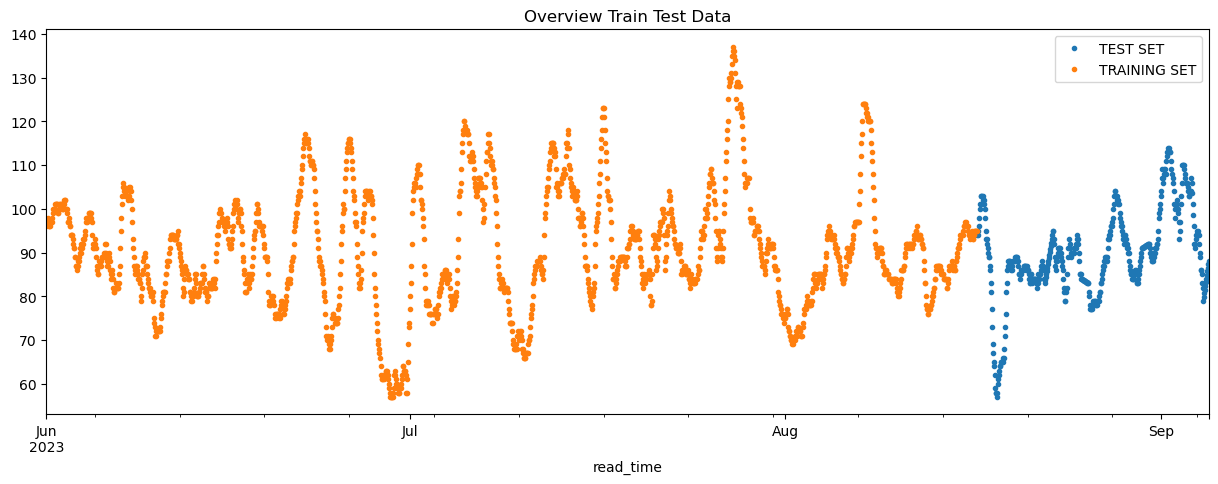

In [14]:
Overview_Train_Test_Data = test_mf_df \
    .rename(columns={'lin_pm25': 'TEST SET'}) \
    .join(train_mf_df.rename(columns={'lin_pm25': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Overview Train Test Data', style='.')

In [16]:
train_mf_df_copy = train_mf_df.copy()
test_mf_df_copy = test_mf_df.copy()

trainX, trainY = xgb_helper.create_features(train_mf_df_copy, target_variable='lin_pm25')
testX, testY = xgb_helper.create_features(test_mf_df_copy, target_variable='lin_pm25')

In [17]:
trainX.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
read_time,,,,,,,,
2023-06-01 00:00:00,0,3,2,6,2023,152,1,22
2023-06-01 01:00:00,1,3,2,6,2023,152,1,22
2023-06-01 02:00:00,2,3,2,6,2023,152,1,22
2023-06-01 03:00:00,3,3,2,6,2023,152,1,22
2023-06-01 04:00:00,4,3,2,6,2023,152,1,22


In [18]:
trainY.head()

read_time
2023-06-01 00:00:00    96.0
2023-06-01 01:00:00    97.0
2023-06-01 02:00:00    97.0
2023-06-01 03:00:00    98.0
2023-06-01 04:00:00    97.0
Name: lin_pm25, dtype: float64

### Baseline model

In [33]:
xgb = XGBRegressor(
        objective='reg:squarederror', 
        n_estimators=1000
)
xgb

xgb.fit(trainX, trainY,
        eval_set=[(trainX, trainY), (testX, testY)],
        early_stopping_rounds=50,
        verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

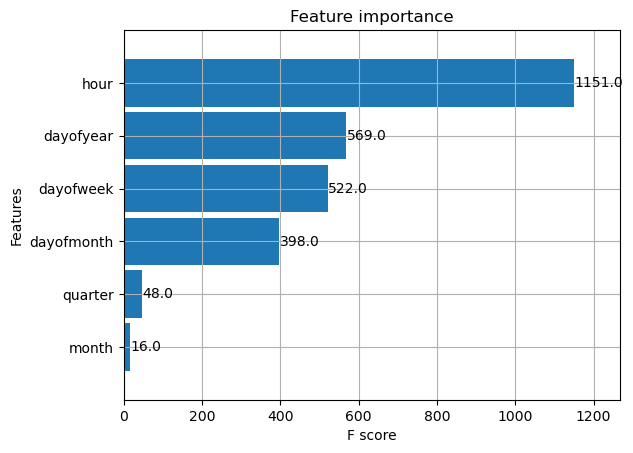

In [34]:
feature_importance = plot_importance(xgb, height=0.9)
feature_importance

In [35]:
predicted_results = xgb.predict(testX)

In [36]:
xgb_helper.timeseries_evaluation_metrics_func(testY, predicted_results)

MSE is : 267.9097434984592
MAE is : 12.472448305560441
RMSE is : 16.36794866495063
MAPE is : 14.073004397948855
R2 is : -1.5050589985010037



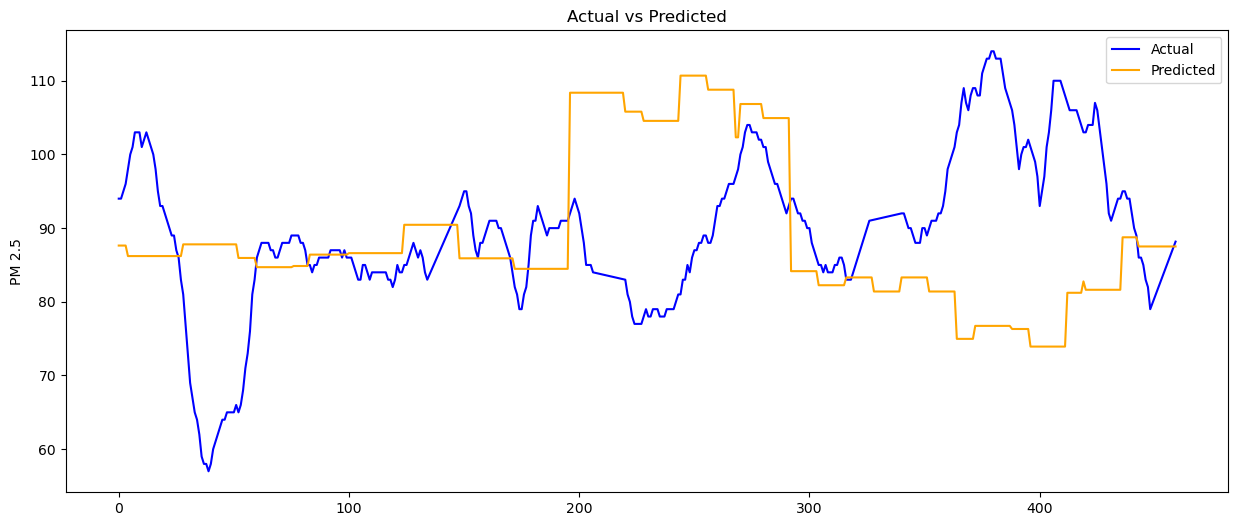

In [39]:
plt.figure(figsize=(15,6))
plt.plot(list(testY), color='blue', label='Actual')
plt.plot(list(predicted_results), color='orange', label='Predicted')
plt.title("Actual vs Predicted")
plt.ylabel("PM 2.5")
plt.legend()
plt.show()

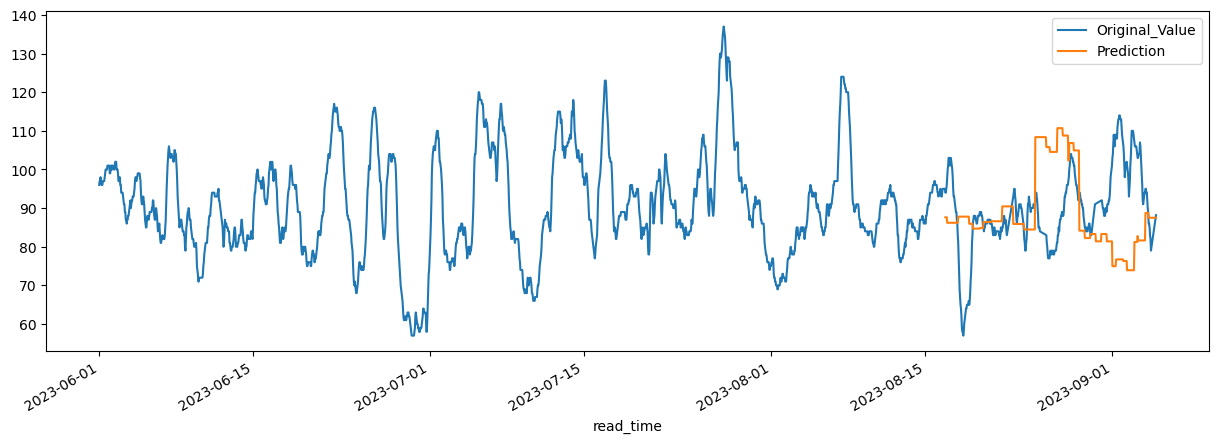

In [40]:
test_mf_df_copy['Prediction'] = predicted_results
pjme_all = pd.concat([test_mf_df_copy, train_mf_df_copy], sort=False)
pjme_all = pjme_all.rename(columns={'lin_pm25':'Original_Value'})

Overview_Complete_Data_And_Prediction = pjme_all[['Original_Value','Prediction']].plot(figsize=(15, 5))

In [41]:
print('Smallest date for which predictions were made: ' )
print(str(test_mf_df_copy.index.min()))

Smallest date for which predictions were made: 
2023-08-16 20:00:00


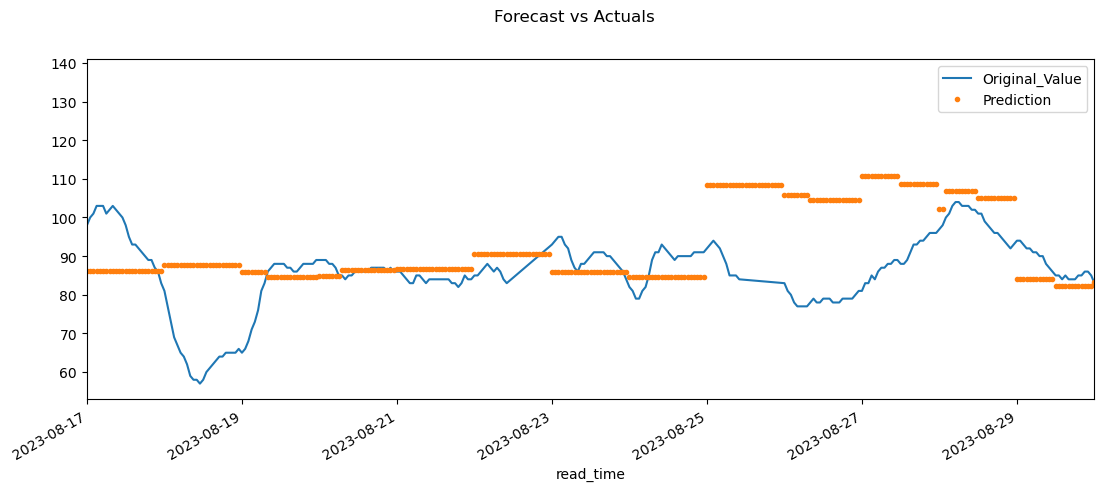

In [43]:
# Plot the forecast with the actuals for Mai
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
Overview_Mai_2015 = pjme_all[['Original_Value', 'Prediction']].plot(ax=ax,
                                                                   style=['-','.'])
ax.set_xbound(lower='2023-08-17', upper='2023-08-30')
# ax.set_ylim(0, 60000)
plot = plt.suptitle('Forecast vs Actuals')

## Final Training Pipeline

In [194]:
stasiun_name = 'Bekasi Kayuringin'

In [195]:
filtered_df = raw_df[raw_df['stasiun'] == stasiun_name][['read_time','lin_pm25']]

# Make sure that you have the correct order of the times
filtered_df['read_time'] = pd.to_datetime(filtered_df['read_time'])
filtered_df = filtered_df.sort_values(by='read_time', ascending=True)

# Set Datetime as index
filtered_df = filtered_df.set_index(['read_time'])

# # convert to log return
# period = 168
# df_logret = np.log(filtered_df).diff(period)
# df_logret.dropna(inplace=True)

In [196]:
# pm_minus_period = xgb_helper.create_delayed_df(filtered_df, period)

In [197]:
# Define the proportions for train, validation, and test sets
train_frac = 0.6  # 60% of the data for training
val_frac = 0.2    # 20% for validation
test_frac = 0.2   # 20% for testing

df_train, df_val, df_test = xgb_helper.xgb_time_train_test_split(
    filtered_df,
    train_frac,
    val_frac,
    test_frac
)

length of train: 1382 | 60% of total length
length of validation: 460 | 20% of total length
length of test: 462 | 20% of total length


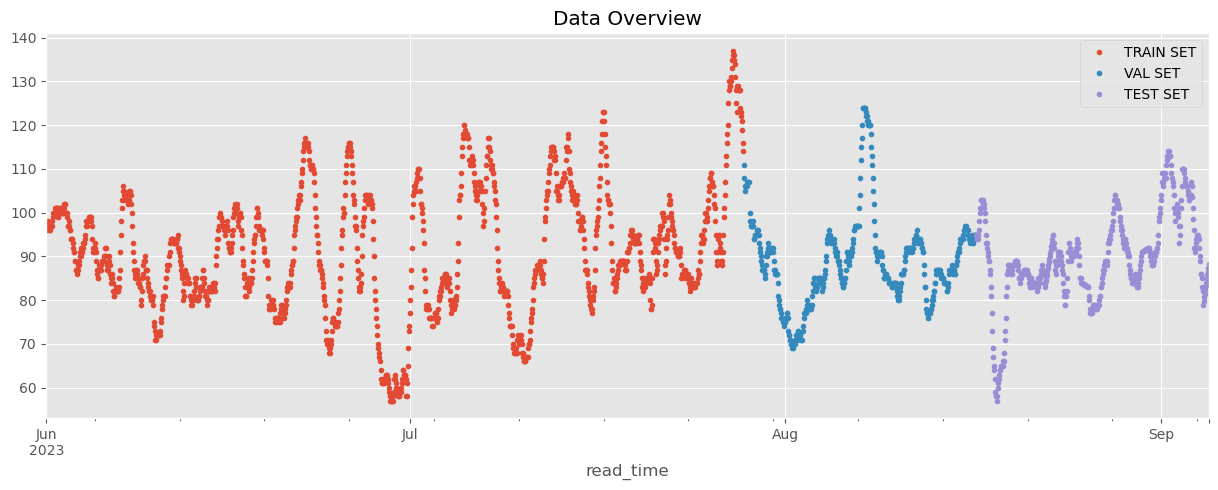

In [198]:
Overview_Data = (
    df_train.rename(columns={'lin_pm25': 'TRAIN SET'})
    .join(df_val.rename(columns={'lin_pm25': 'VAL SET'}), how='outer')
    .join(df_test.rename(columns={'lin_pm25': 'TEST SET'}), how='outer')
    .plot(figsize=(15,5), title='Data Overview', style='.')
)

In [199]:
train_x, train_y = xgb_helper.create_features(df_train, target_variable='lin_pm25')
val_x, val_y = xgb_helper.create_features(df_val, target_variable='lin_pm25')
test_x, test_y = xgb_helper.create_features(df_test, target_variable='lin_pm25')

In [203]:
param = {
    'max_depth': 3,
    'eta': 0.05,
    'objective': 'reg:squarederror',
    'subsample': 0.6,
    'colsample_bytree': 0.8,
}

xgb_model, train_pred, train_rmse, val_pred, val_rmse, eval_result = xgb_engine.xgb_train(
    train_x, train_y,
    val_x, val_y,
    param,
    100,
    pruning_callback=None
)

In [ ]:
print(train_rmse)
print(val_rmse)

7.055217390581021
28.462528976647185


Text(0, 0.5, 'pm 2.5 level')

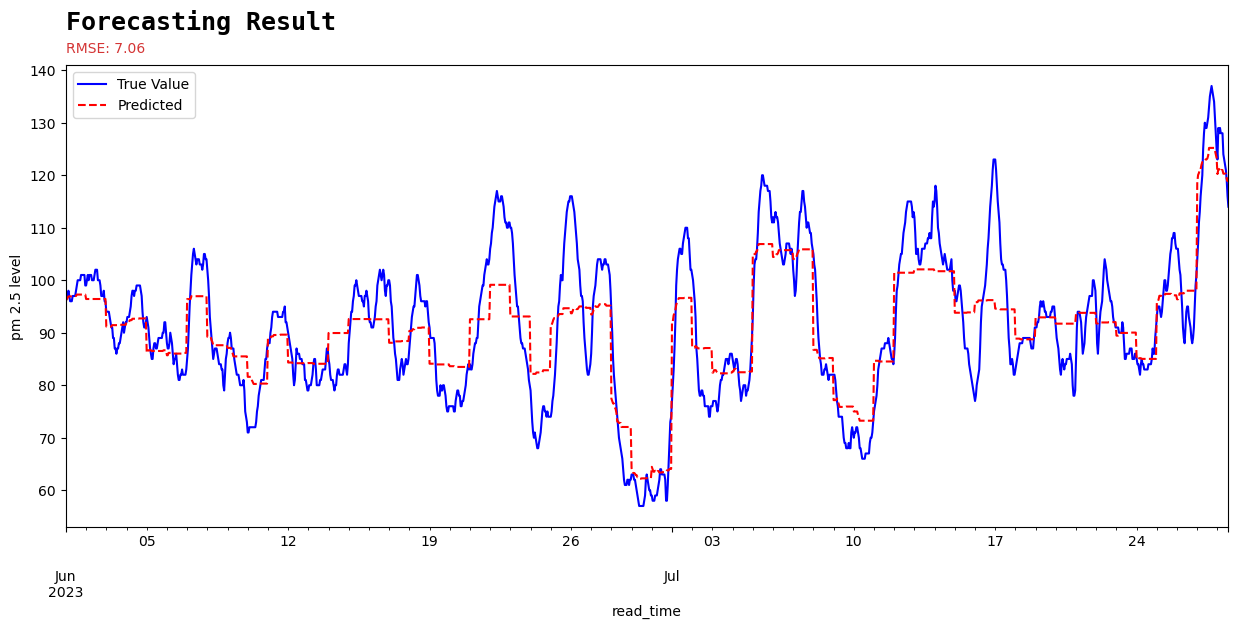

In [ ]:
fig, ax = xgb_helper.xgb_predict_plot(
    train_y,
    train_pred
)

title = "<name:monospace, size:18><weight:bold>Forecasting Result</></>"
flexitext(0, 1.12, title, va="top", ax=ax)

subtitle = (
    f"<color: #d43535>RMSE: {train_rmse:.2f}</>"
)
flexitext(0, 1.05, subtitle, va="top", ax=ax)

ax.set_ylabel("pm 2.5 level")

Text(0, 0.5, 'pm 2.5 level')

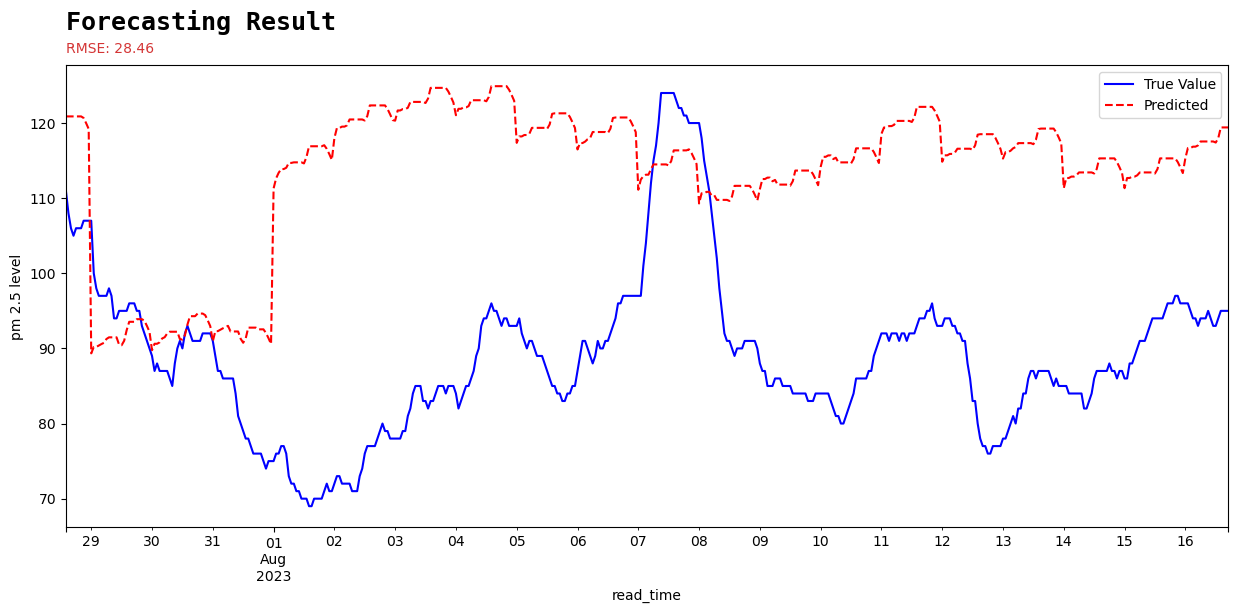

In [ ]:
fig, ax = xgb_helper.xgb_predict_plot(
    val_y,
    val_pred
)

title = "<name:monospace, size:18><weight:bold>Forecasting Result</></>"
flexitext(0, 1.12, title, va="top", ax=ax)

subtitle = (
    f"<color: #d43535>RMSE: {val_rmse:.2f}</>"
)
flexitext(0, 1.05, subtitle, va="top", ax=ax)

ax.set_ylabel("pm 2.5 level")

In [ ]:
test_pred = xgb_engine.xgb_predict(xgb_model, test_x)
fig, ax = xgb_helper.xgb_predict_plot(
    test_y,
    test_pred
)

In [ ]:
np.sqrt(metrics.mean_squared_error(test_y, test_pred))

28.23888212460334

# Experimentation

General Approach for Parameter Tuning
We will use an approach similar to that of GBM here. The various steps to be performed are:

1. Choose a relatively high learning rate. Generally, a learning rate of 0.1 works, but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
1. Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for the decided learning rate and the number of trees. Note that we can choose different parameters to define a tree, and I’ll take up an example here.
1. Tune regularization parameters (lambda, alpha) for xgboost, which can help reduce model complexity and enhance performance.
1. Lower the learning rate and decide the optimal parameters.

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
# xgb1 = XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)

## MLflow

## Data Preparation

In [7]:
stasiun_name = 'Bekasi Kayuringin'

In [87]:
filtered_df = raw_df[raw_df['stasiun'] == stasiun_name][['read_time','lin_pm25']]

# Make sure that you have the correct order of the times
filtered_df['read_time'] = pd.to_datetime(filtered_df['read_time'])
filtered_df = filtered_df.sort_values(by='read_time', ascending=True)

# Set Datetime as index
filtered_df = filtered_df.set_index(['read_time'])

# # convert to log return
# period = 168
# df_logret = np.log(filtered_df).diff(period)
# df_logret.dropna(inplace=True)

In [88]:
# pm_minus_period = xgb_helper.create_delayed_df(filtered_df, period)

In [89]:
# Define the proportions for train, validation, and test sets
train_frac = 0.6  # 60% of the data for training
val_frac = 0.2    # 20% for validation
test_frac = 0.2   # 20% for testing

df_train, df_val, df_test = xgb_helper.xgb_time_train_test_split(
    filtered_df,
    train_frac,
    val_frac,
    test_frac
)

length of train: 1382 | 60% of total length
length of validation: 460 | 20% of total length
length of test: 462 | 20% of total length


In [90]:
train_x, train_y = xgb_helper.create_features(df_train, target_variable='lin_pm25')
val_x, val_y = xgb_helper.create_features(df_val, target_variable='lin_pm25')
test_x, test_y = xgb_helper.create_features(df_test, target_variable='lin_pm25')

to encode
- hour - max 23
- dayofweek - 6
- dayofmonth - 30
- if have multiple year
    - month - 11
    - dayofyear - 365

to drop
- year

In [91]:
def encode(data, col, max_val):
    if not max_val:
        max_val = data[col].max()
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data.drop(columns=[col], inplace=True)

In [92]:
for df in (train_x, val_x, test_x):
    for granularity, max in zip(['hour','dayofweek','dayofmonth'],[23,6,30]):
        # print(f"encoding {granularity}")
        encode(df, granularity, max)
    # print("dropping..")
    df.drop(columns=['year'], inplace=True)

In [93]:
train_x.head(2)

,quarter,month,dayofyear,weekofyear,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,dayofmonth_sin,dayofmonth_cos
read_time,,,,,,,,,,
2023-06-01 00:00:00,2,6,152,22,0.000000,1.000000,1.224647e-16,-1.0,0.207912,0.978148
2023-06-01 01:00:00,2,6,152,22,0.269797,0.962917,1.224647e-16,-1.0,0.207912,0.978148


In [97]:
with open(secret_dir/"mlflow_dagshub.json", "r") as f:
    secrets = json.load(f)

In [98]:
os.environ['MLFLOW_TRACKING_USERNAME'] = secrets['MLFLOW_TRACKING_USERNAME']
os.environ['MLFLOW_TRACKING_PASSWORD'] = secrets['MLFLOW_TRACKING_PASSWORD']
os.environ['MLFLOW_TRACKING_URI'] = secrets['MLFLOW_TRACKING_URI']

In [99]:
base_exp_name = "fe_xgboost_optuna"
experiment_name = datetime.datetime.now().strftime("%Y%m%d") # returns current date in YYYY-MM-DD format
experiment_name = base_exp_name + "_" + experiment_name

# experiment_name = "xgboost_optuna_test"

# Check if the experiment exists, and if not, create it
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

# tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

In [100]:
@mlflc.track_in_mlflow()
def objective(trial):
    param = {
        'objective': trial.suggest_categorical('objective',[
            'reg:squarederror',
            # 'reg:absoluteerror',
            # 'reg:pseudohubererror'
            ]),
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'eta': trial.suggest_float('eta', 1e-4, 0.1),
        # 'subsample': trial.suggest_float('subsample', 0.4, 0.8),
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.8),
        # 'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        # 'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
    }

    # callback = optuna.integration.XGBoostPruningCallback(trial, "test-rmse")
    xgb_model, train_pred, train_rmse, val_pred, val_rmse, eval_result = xgb_engine.xgb_train(
        train_x,
        train_y,
        val_x,
        val_y,
        param,
        1000,
        # pruning_callback=[None]
    )
    
    fig, ax = xgb_helper.xgb_predict_plot(
        train_y,
        train_pred
    )
    mlflow.log_figure(fig, "img/train_plot.png")
    plt.close()

    fig, ax = xgb_helper.xgb_predict_plot(
        val_y,
        val_pred
    )
    mlflow.log_figure(fig, "img/validation_plot.png")
    plt.close()
    
    # results
    epochs = len(eval_result['train']['rmse'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, eval_result['train']['rmse'], label='Train')
    ax.plot(x_axis, eval_result['valid']['rmse'], label='Validation')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('XGBoost RMSE by Epoch')
    mlflow.log_figure(fig, "img/rmse_by_epoch.png")
    plt.close()
    
    mlflow.log_dict(eval_result, "eval_result/eval_result.json")
    mlflow.log_metric("train_rmse", train_rmse)

    return val_rmse

In [101]:
# %%capture

mlflc = MLflowCallback(
    tracking_uri=secrets["MLFLOW_TRACKING_URI"],
    metric_name="validation-rmse",
)
n_trial = 100
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
study = optuna.create_study(study_name=experiment_name, pruner=pruner, direction="minimize")
study.optimize(objective, n_trials=n_trial, callbacks=[mlflc])

# # Retrieve the best trial and its parameters
# best_trial = study.best_trial
# best_params = best_trial.params

# # Train the best model using the best hyperparameters
# best_model = xgb_engine.xgb_train(train_x, train_y, val_x, val_y, best_params, 1000)

# # Log the best model in MLflow
# with mlflow.start_run():
#     mlflow.log_params(best_params)
#     mlflow.xgboost.log_model(best_model, artifact_path="best_xgboost_model")

[I 2023-09-18 21:08:35,193] A new study created in memory with name: fe_xgboost_optuna_20230918
[I 2023-09-18 21:08:40,032] Trial 0 finished with value: 25.312052110378414 and parameters: {'objective': 'reg:squarederror', 'max_depth': 19, 'eta': 0.050689320476642236}. Best is trial 0 with value: 25.312052110378414.
[I 2023-09-18 21:08:48,017] Trial 1 finished with value: 13.93379014306383 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'eta': 0.014965624832979788}. Best is trial 1 with value: 13.93379014306383.
[I 2023-09-18 21:08:55,701] Trial 2 finished with value: 28.71433370814772 and parameters: {'objective': 'reg:squarederror', 'max_depth': 3, 'eta': 0.09654620519026744}. Best is trial 1 with value: 13.93379014306383.
[I 2023-09-18 21:09:03,408] Trial 3 finished with value: 33.38792844744693 and parameters: {'objective': 'reg:squarederror', 'max_depth': 47, 'eta': 0.09397206401460395}. Best is trial 1 with value: 13.93379014306383.
[I 2023-09-18 21:09:11,254] T

In [102]:
mlflow.end_run()

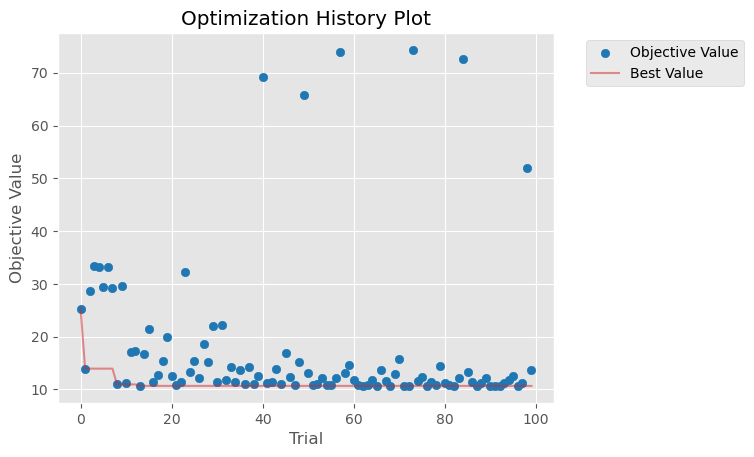

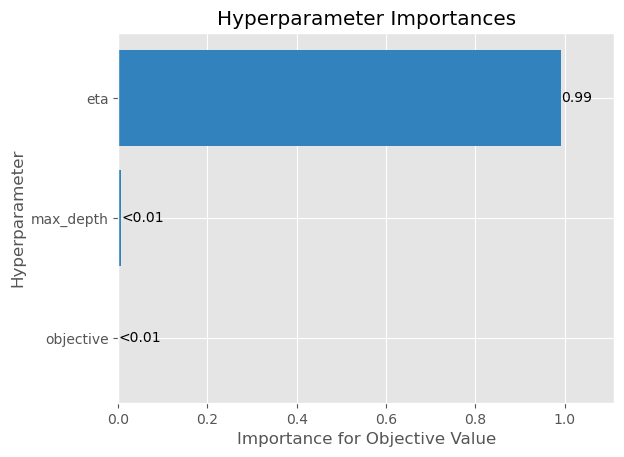

In [104]:
optim_history = optuna.visualization.matplotlib.plot_optimization_history(study)
importance_plot = optuna.visualization.matplotlib.plot_param_importances(study)

# Inference

In [105]:
# Retrieve the best trial and its parameters
best_trial = study.best_trial
best_params = best_trial.params

# Train the best model using the best hyperparameters
best_model, train_pred, train_rmse, val_pred, val_rmse, evals_result = xgb_engine.xgb_train(train_x, train_y, val_x, val_y, best_params, 1000)

Text(0, 0.5, 'pm 2.5 level')

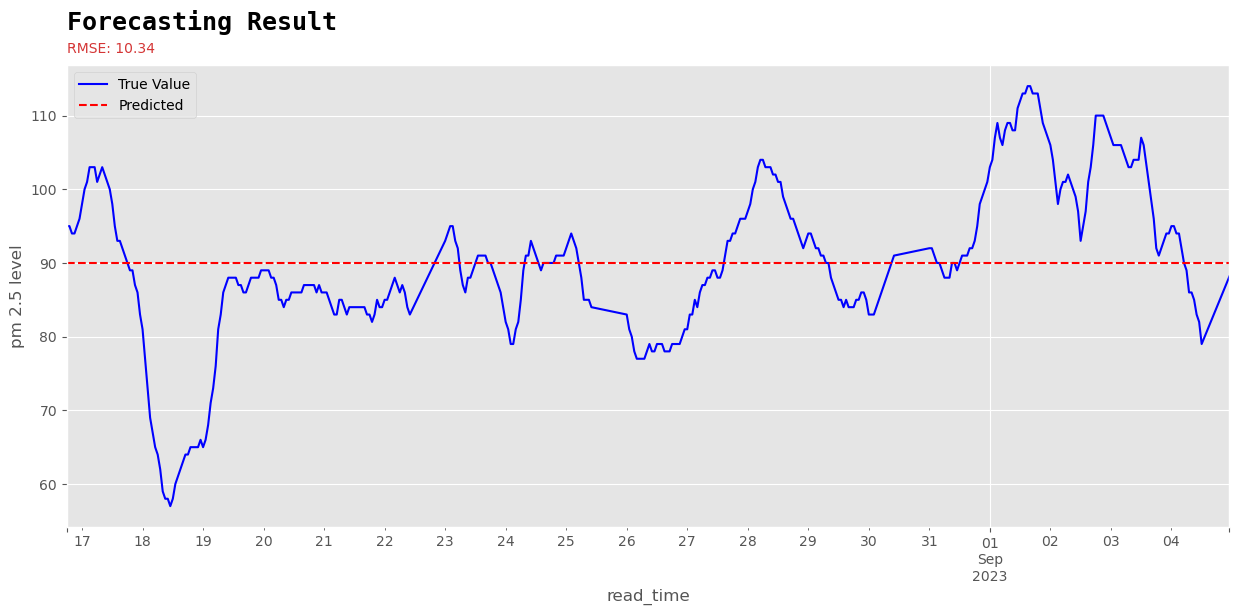

In [107]:
test_pred = xgb_engine.xgb_predict(best_model, test_x)
fig, ax = xgb_helper.xgb_predict_plot(
    test_y,
    test_pred
)

test_rmse = np.sqrt(metrics.mean_squared_error(test_y, test_pred))

title = "<name:monospace, size:18><weight:bold>Forecasting Result</></>"
flexitext(0, 1.12, title, va="top", ax=ax)

subtitle = (
    f"<color: #d43535>RMSE: {test_rmse:.2f}</>"
)
flexitext(0, 1.05, subtitle, va="top", ax=ax)

ax.set_ylabel("pm 2.5 level")

In [108]:
print(np.sqrt(((test_y - test_pred)**2).mean()))

10.337265592031132
